# Installation des dépendances

In [1]:
!pip install Pillow smartcrop matplotlib tensorflow numpy

  Using cached smartcrop-0.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached PyGObject-3.46.0.tar.gz (723 kB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
        Using cached setuptools-69.0.2-py3-none-any.whl.metadata (6.3 kB)
        Using cached wheel-0.42.0-py3-none-any.whl.metadata (2.2 kB)
        Using cached pycairo-1.25.1.tar.gz (347 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Installing backend dependencies: started
        Installing backend dependencies: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
     

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow.keras as K

# Preparation du dataset

In [4]:
from pathlib import Path

path_to_dataset = Path("data/dataset_dojo")
path_to_cropped = path_to_dataset / "cropped"
path_to_models = Path("out/models")

img_height = 300
img_width = 300

In [5]:
import tensorflow as tf
from modules import dataload

training_dataset = dataload.create_set(path_to_cropped, "training")
validation_dataset = dataload.create_set(path_to_cropped, "validation")

class_names = training_dataset.class_names
print(f"{class_names = }")
print(f"{len(class_names) = }")

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#TODO : Ajouter un split de test pour comparer les differents types de modèles

Found 0 images in data/dataset_dojo/cropped.
Found 800 files belonging to 8 classes.
Using 640 files for training.
Found 0 images in data/dataset_dojo/cropped.
Found 800 files belonging to 8 classes.
Using 160 files for validation.
class_names = ['celtis_australis', 'juniperus_procera', 'juniperus_thurifera', 'markhamia_lutea', 'milicia_excelsa', 'pino_halepensis', 'prunus_africana', 'unknown']
len(class_names) = 8


In [6]:
import numpy as np
from tensorflow import keras as K

image_batch, _ = next(iter(training_dataset))
first_image = image_batch[0]
print(f"Initial image values interval : [{np.min(first_image)}, {np.max(first_image)}]")

normalization_layer = K.layers.Rescaling(1./255)
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(f"Normalized image values interval : [{np.min(first_image)}, {np.max(first_image)}]")

Initial image values interval : [3.682278871536255, 255.0]
Normalized image values interval : [0.0, 0.9750927686691284]


# Modèle simple

In [7]:
from modules.model import create_model

num_classes = len(class_names)

model = create_model(
    input_shape=(img_height, img_width, 3),
    output_dim=num_classes
)

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)       

## Entrainement du modèle simple

In [29]:
epochs=30

history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 12s 588ms/step - loss: 7.8066e-05 - accuracy: 1.0000 - val_loss: 4.3467 - val_accuracy: 0.4125
Epoch 2/30
20/20 [==============================] - 12s 584ms/step - loss: 7.5629e-05 - accuracy: 1.0000 - val_loss: 4.3612 - val_accuracy: 0.4125
Epoch 3/30
20/20 [==============================] - 12s 583ms/step - loss: 7.3685e-05 - accuracy: 1.0000 - val_loss: 4.3627 - val_accuracy: 0.4125
Epoch 4/30
20/20 [==============================] - 12s 583ms/step - loss: 7.0557e-05 - accuracy: 1.0000 - val_loss: 4.3746 - val_accuracy: 0.4125
Epoch 5/30
20/20 [==============================] - 12s 585ms/step - loss: 6.8510e-05 - accuracy: 1.0000 - val_loss: 4.3790 - val_accuracy: 0.4125
Epoch 6/30
20/20 [==============================] - 12s 581ms/step - loss: 6.6090e-05 - accuracy: 1.0000 - val_loss: 4.3934 - val_accuracy: 0.4125
Epoch 7/30
20/20 [==============================] - 12s 593ms/step - loss: 6.3796e-05 - accuracy: 1.0000 - val_loss: 4

## Visualisation des métriques

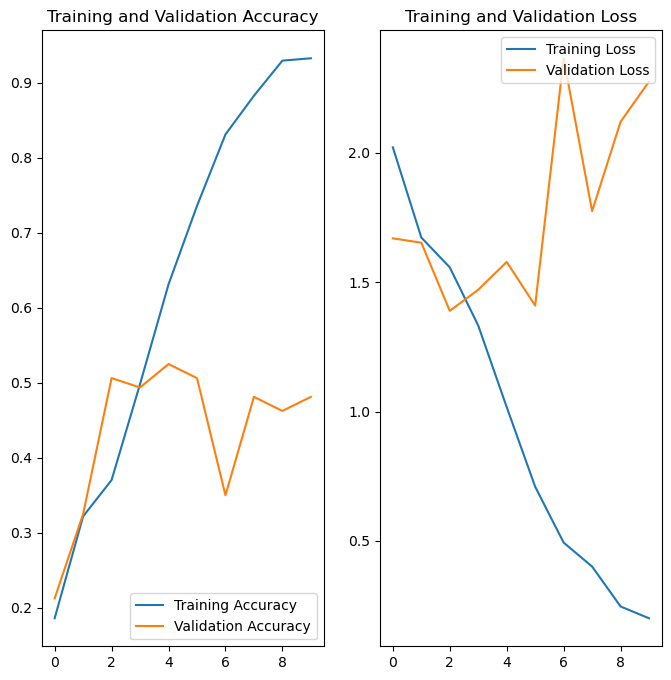

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sauvegarde

In [12]:
from modules.model import save_model
save_model(
    model_folder=path_to_models / "simple",
    model=model,
)

# Augmentation du modele

## Illustration de la couche d'augmentation

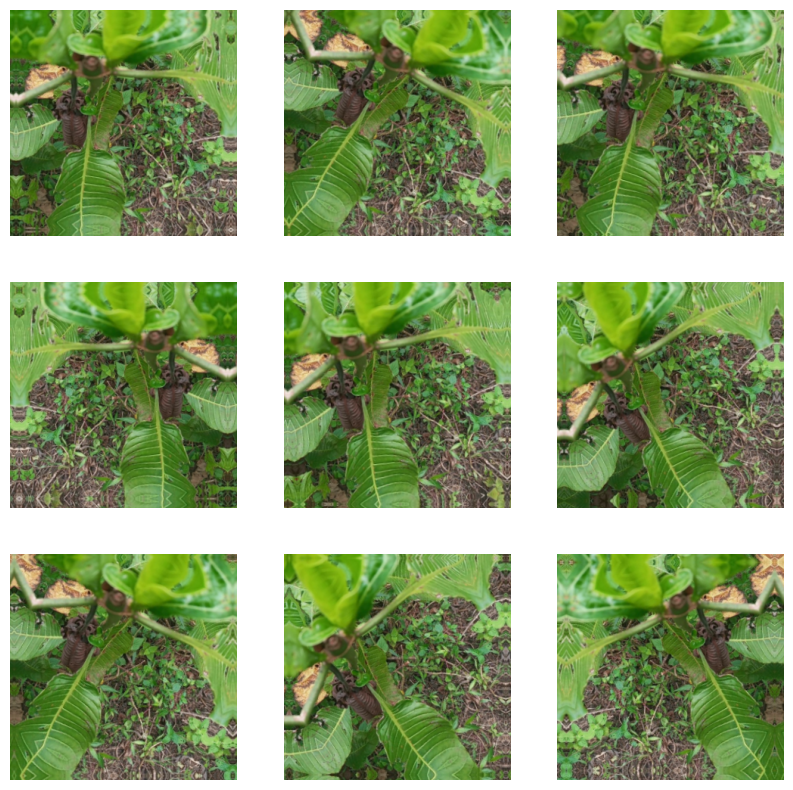

In [13]:
data_augmentation = K.Sequential([
    K.layers.RandomFlip(
        "horizontal",
        input_shape=(img_height, img_width, 3)
    ),
    K.layers.RandomRotation(0.1),
    K.layers.RandomZoom(0.1),
])

plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Déclaration du modèle augmenté

In [14]:
augmented_model = create_model(
    input_shape=(img_height, img_width, 3),
    output_dim=num_classes,
    augmented=True,
)

In [15]:
augmented_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [16]:
augmented_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                 

## Entrainement du modèle augmenté

In [17]:
epochs=30
history_aug = augmented_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
20/20 [==============================] - 14s 682ms/step - loss: 3.3334 - accuracy: 0.1328 - val_loss: 1.8910 - val_accuracy: 0.2438
Epoch 2/10
20/20 [==============================] - 13s 666ms/step - loss: 1.8691 - accuracy: 0.2438 - val_loss: 1.7250 - val_accuracy: 0.3313
Epoch 3/10
20/20 [==============================] - 13s 632ms/step - loss: 1.7739 - accuracy: 0.2859 - val_loss: 1.5608 - val_accuracy: 0.4062
Epoch 4/10
20/20 [==============================] - 13s 630ms/step - loss: 1.6973 - accuracy: 0.3344 - val_loss: 1.5352 - val_accuracy: 0.4437
Epoch 5/10
20/20 [==============================] - 13s 633ms/step - loss: 1.7303 - accuracy: 0.3125 - val_loss: 1.6205 - val_accuracy: 0.3125
Epoch 6/10
20/20 [==============================] - 13s 664ms/step - loss: 1.6343 - accuracy: 0.3406 - val_loss: 1.5344 - val_accuracy: 0.3250
Epoch 7/10
20/20 [==============================] - 14s 684ms/step - loss: 1.5646 - accuracy: 0.4094 - val_loss: 1.4114 - val_accuracy: 0.5000

## Sauvegarde et affichage des métriques

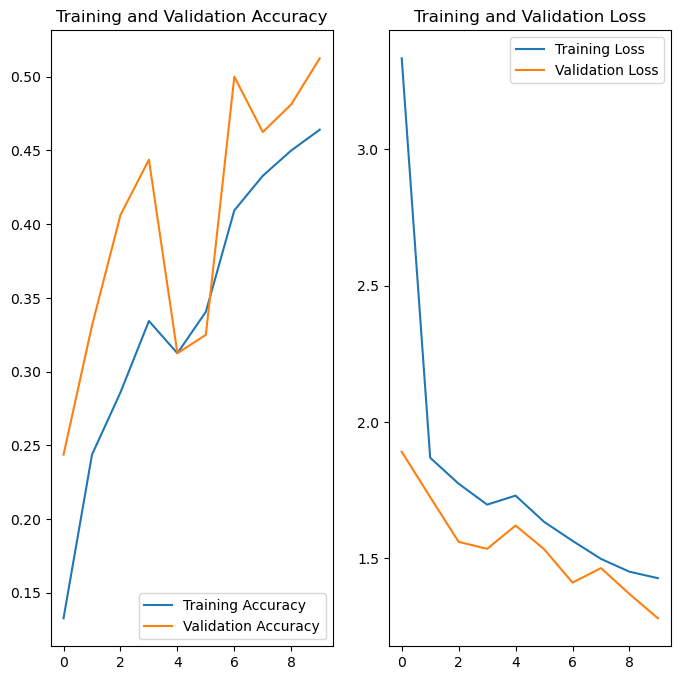

In [18]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sauvegarde

In [19]:
from modules.model import save_model
save_model(
    model_folder=path_to_models / "augmented",
    model=augmented_model,
)

# Résultats

## Exemple d'inférence

1/1 [==============================] - 0s 63ms/step
This image most likely belongs to unknown with a 99.99 percent confidence.


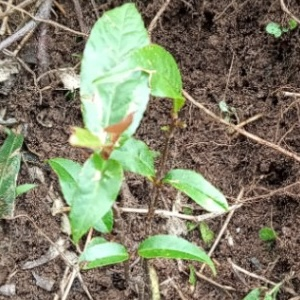

In [20]:
import os
from PIL import Image

test_file_url = "test_celtis_australis_cropped.jpeg"
im = Image.open(os.path.abspath("./" + test_file_url)) 

sunflower_path = tf.keras.utils.get_file(fname='test-file', origin='file://'+os.path.abspath("./" + test_file_url))

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

display(im)

## Comparaison du modèle simple et du modèle augmenté

In [26]:
def test_predict(path, model):
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    return {
        'path': path,
        'class': class_names[np.argmax(score)], 
        'score': 100 * np.max(score)
    }

In [27]:
from modules.dataload import get_images

predictions = [test_predict(img, augmented_model) for img in get_images("data/dataset_dojo/cropped", 1000)]

1/1 [==============================] - 0s 24ms/step


In [30]:
import pandas as pd

pd.DataFrame(predictions).groupby('class').count()

,path,score
class,,
celtis_australis,133,133
juniperus_procera,114,114
juniperus_thurifera,165,165
markhamia_lutea,128,128
milicia_excelsa,75,75
pino_halepensis,25,25
prunus_africana,63,63
unknown,97,97
